In [42]:
# Wide-ResNet
#
#
#
#
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
!pip3 install matplotlib

     |████████████████████████████████| 8.5 MB 8.5 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 7.3 MB/s eta 0:00:011
     |████████████████████████████████| 2.8 MB 24.7 MB/s eta 0:00:01


In [43]:
import pickle
import os
import math
import numpy as np

from datetime import datetime
from matplotlib import pyplot as plt
from IPython.display import Image

import tensorflow as tf
import keras as K

from keras.layers import Input, Conv2D, Dense
from keras.layers import BatchNormalization, SpatialDropout2D
from keras.layers import Activation, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras.callbacks import LearningRateScheduler
from keras.utils.vis_utils import plot_model

print('Keras Version:', K.__version__)
print('Keras Backend:', K.backend.backend())
print('Keras Image Data Format:', K.backend.image_data_format())
print('TensorFlow Version:', tf.__version__)

Keras Version: 2.3.1
Keras Backend: tensorflow
Keras Image Data Format: channels_last
TensorFlow Version: 2.0.0


In [44]:
# define data directory and helper functions
DATA_PATH = "cifar-10-batches-py/"

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_batch(batch_name):
    batch = os.path.join(DATA_PATH, batch_name)
    batch_dict = unpickle(batch)
    print('Loading %s' % batch_dict[b'batch_label'].decode('ascii'))
    X_data_ = batch_dict[b'data']
    X_data_ = X_data_.reshape(10000, 3, 32, 32)  # separate RGB channels
    X_data_ = X_data_.transpose(0,2,3,1).astype("float")  # re-order
    y_labels_ = batch_dict[b'labels']
    img_filenames_ = batch_dict[b'filenames']
    return (X_data_, y_labels_, img_filenames_)

In [83]:
# load training data
TRAIN_BATCH_LIST = [("data_batch_%s" % i) for i in range(1,6)]
X_arrs, y_arrs, name_arrs = [], [], []
for batch_name in TRAIN_BATCH_LIST:
    (X_arr, y_arr, name_arr) = load_batch(batch_name)
    X_arrs.append(X_arr)
    y_arrs.append(np.array(y_arr))
    name_arrs.append(name_arr)
X_train = np.vstack(X_arrs).astype('float32')
y_train = np.hstack(y_arrs)
img_filenames_train = np.vstack(name_arrs)
    
# load test data     
(X_test, y_test, img_filenames_test) = load_batch('test_batch')
y_test = np.array(y_test)

# ensure desired data format
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

# define label dictionary
label_dict = {0: 'airplane', 
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

# use final 5000 training samples (10%) as validation set
X_val = X_train[45000:].astype('float32')
y_val = y_train[45000:]
X_train = X_train[:45000].astype('float32')
y_train = y_train[:45000]

# print data shapes
print('\nX_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

Loading training batch 1 of 5
Loading training batch 2 of 5
Loading training batch 3 of 5
Loading training batch 4 of 5
Loading training batch 5 of 5
Loading testing batch 1 of 1

X_train shape: (45000, 32, 32, 3)
X_val shape: (5000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)
y_train shape: (45000,)
y_val shape: (5000,)
y_test shape: (10000,)


In [45]:
def get_onehot(y_data, num_classes=10):
    return K.utils.to_categorical(y_data, num_classes)

In [59]:
# augmented image generator based on scheme
# recommended by Zagoruyko and Komodakis
train_datagen_1 = ImageDataGenerator(
    featurewise_center=True, 
    samplewise_center=False, 
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False, 
    zca_whitening=True, 
    zca_epsilon=1e-06, 
    rotation_range=0.0, 
    width_shift_range=0.25, 
    height_shift_range=0.25, 
    brightness_range=None, 
    shear_range=0.0, 
    zoom_range=0.0, 
    channel_shift_range=0.0, 
    fill_mode='reflect', 
    cval=0.0, 
    horizontal_flip=True, 
    vertical_flip=False, 
    rescale=None, 
    preprocessing_function=None, 
    data_format='channels_last', 
    validation_split=0.0)

# an alternative image augmentation scheme
# using zooms, rotations, and shears
train_datagen_2 = ImageDataGenerator(
    featurewise_center=True, 
    samplewise_center=False, 
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False, 
    zca_whitening=True, 
    zca_epsilon=1e-06, 
    rotation_range=15.0, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    brightness_range=None, 
    shear_range=0.2, 
    zoom_range=0.2, 
    channel_shift_range=0.0, 
    fill_mode='nearest', 
    cval=0.0, 
    horizontal_flip=True, 
    vertical_flip=False, 
    rescale=None, 
    preprocessing_function=None, 
    data_format='channels_last', 
    validation_split=0.0)

# for the test set, apply ZCA and centering only
test_datagen = ImageDataGenerator(
    featurewise_center=True,                        
    zca_whitening=True,                     
    data_format='channels_last')

# data normalization and ZCA whitening require our 
# generators to first be fit on our training data
train_datagen_1.fit(np.vstack((X_train, X_val)))
train_datagen_2.fit(np.vstack((X_train, X_val)))
test_datagen.fit(np.vstack((X_train, X_val)))

In [60]:
# sample image to augment
x_temp = X_train[4].reshape(1, 32, 32, 3)

# recreate the generators but without ZCA whitening
demo_datagen_1 = ImageDataGenerator(
    rotation_range=0.0, 
    width_shift_range=0.25, 
    height_shift_range=0.25, 
    fill_mode='reflect', 
    horizontal_flip=True, 
    data_format='channels_last')

demo_datagen_2 = ImageDataGenerator(
    rotation_range=15.0, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2, 
    fill_mode='nearest', 
    horizontal_flip=True, 
    data_format='channels_last')


Data Augmentation Scheme 1:


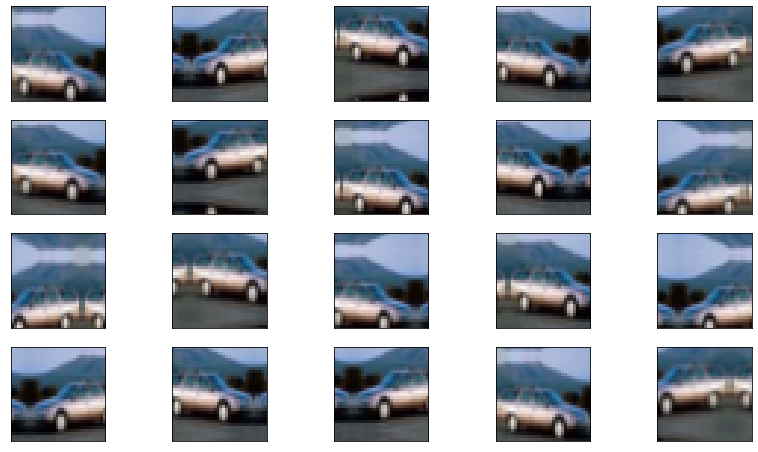

In [61]:
# plot examples from scheme 1
print('\nData Augmentation Scheme 1:')
i=0
figure = plt.figure(figsize=(14, 8))
for batch in demo_datagen_1.flow(x_temp, batch_size=1):
    # display the images
    ax = figure.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
    img = np.squeeze(batch).astype('uint8')
    ax.imshow(img, interpolation='nearest')
    i+=1
    if i==20:  # otherwise the generator would continue indefinitely
        break


Data Augmentation Scheme 2:


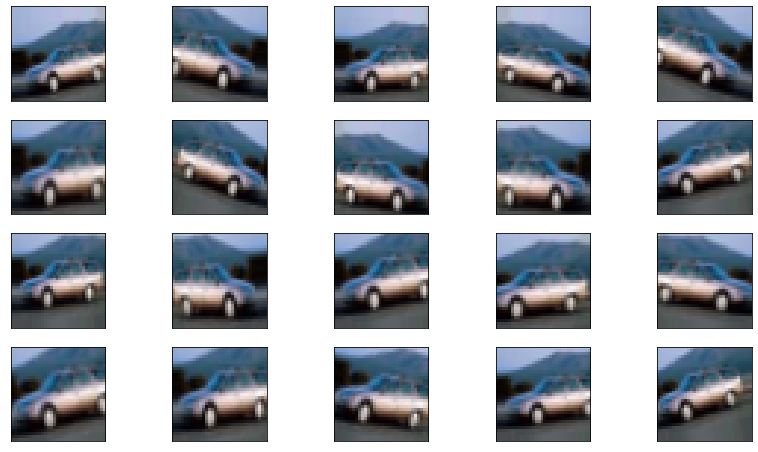

In [62]:
# plot examples from scheme 2
print('\nData Augmentation Scheme 2:')
i=0
figure = plt.figure(figsize=(14, 8))
for batch in demo_datagen_2.flow(x_temp, batch_size=1):
    # display the images
    ax = figure.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
    img = np.squeeze(batch).astype('uint8')
    ax.imshow(img, interpolation='nearest')
    i+=1
    if i==20:  # otherwise the generator would continue indefinitely
        break

In [63]:
def build_SVGG():

    model = K.Sequential()

    # 1. First Conv block
    model.add(Conv2D(filters=64, 
                     kernel_size=3, 
                     padding='same', 
                     activation='relu',
                     input_shape=(32, 32, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(filters=64, 
                     kernel_size=3, 
                     padding='same', 
                     activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=2))

    
    # 2. Second Conv block
    model.add(Conv2D(filters=128, 
                     kernel_size=3, 
                     padding='same', 
                     activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(filters=128, 
                     kernel_size=3, 
                     padding='same', 
                     activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=2))


    # 3. Third Conv block
    model.add(Conv2D(filters=256, 
                     kernel_size=3, 
                     padding='same', 
                     activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(filters=256, 
                     kernel_size=3, 
                     padding='same', 
                     activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=2))


    # 4. Dense layer with dropout applied to flattened data
    model.add(K.layers.Flatten())
    model.add(K.layers.Dense(1024, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.Dense(10, activation='softmax'))
    
    return model

# for inspection purposes
model_SVGG = build_SVGG()
model_SVGG.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_38 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_39 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_40 (Batc (None, 16, 16, 128)      

In [68]:
# perform all tasks related to model training
def compile_and_train(model, 
                      MODEL_NAME,
                      X_train_data, 
                      y_train_data, 
                      X_val_data, 
                      y_val_data,
                      train_generator,
                      test_generator,
                      BATCH_SIZE, 
                      EPOCHS,
                      optimizer='rmsprop', 
                      lr_schedule_fn=None,
                      starting_epoch=0):
    
    # directory setup for saving model files
    MODEL_DIR = 'cifar-10-batches-py/'
    
    DIR = os.path.join(
        MODEL_DIR,           
        MODEL_NAME, 
        datetime.now().strftime('%Y%m%d-%H%M%S'))
    
    if not os.path.exists(DIR):
        os.makedirs(DIR)    
    
    LOG_DIR = os.path.join(DIR, 'logs')
    
    # checkpointer callback for saving best weights
    WEIGHT_DIR = os.path.join(DIR, 'best_weights.hdf5')
    checkpointer_cb = K.callbacks.ModelCheckpoint(
        filepath=WEIGHT_DIR, 
        verbose=1, 
        save_best_only=True)
        
    # callback to save tensorboard logs
    tensorboard_cb = TensorBoard(
        log_dir=LOG_DIR, 
        histogram_freq=0,            
        batch_size=BATCH_SIZE,           
        write_graph=True,           
        write_grads=False,           
        write_images=False)

    print('To view graph generated by TensorBoard,')
    print('copy+paste the following into terminal:')
    print('\ntensorboard --logdir=%s' % LOG_DIR)
    print('\n')
    
    # special callbacks for a scheduled learning rate
    if lr_schedule_fn is not None: 

        # learning rate scheduler
        lr_schedule_cb =K.callbacks.LearningRateScheduler(
            lr_schedule, verbose=0)

        # custom history callback
        class LossHistory(K.callbacks.Callback):
            def on_train_begin(self, logs={}):
                self.losses = []
                self.lr = []

            def on_epoch_end(self, batch, logs={}):
                self.losses.append(logs.get('loss'))
                self.lr.append(lr_schedule(len(self.losses)))

        loss_and_lr_history_cb = LossHistory()

        callback_list = [checkpointer_cb, 
                         tensorboard_cb, 
                         lr_schedule_cb,
                         loss_and_lr_history_cb]
    else:
    
        callback_list = [checkpointer_cb, 
                         tensorboard_cb]    

    # compile the model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    # one-hot encode labels
    y_train_data_onehot = get_onehot(y_train_data)
    y_val_data_onehot = get_onehot(y_val_data)
    
    # prepare data generators
    train_gen = train_generator.flow(
        X_train_data, 
        y_train_data_onehot, 
        batch_size=BATCH_SIZE)
    
    val_gen = test_generator.flow(
        X_val_data, 
        y_val_data_onehot, 
        batch_size=BATCH_SIZE)
    
    # train the model
    history= model.fit_generator(
        generator=train_gen,    
        steps_per_epoch=len(X_train_data)/BATCH_SIZE,       
        epochs=EPOCHS,      
        verbose=1,      
        callbacks=callback_list,       
        validation_data=val_gen,    
        validation_steps=len(X_val_data)/BATCH_SIZE,        
        class_weight=None,       
        max_queue_size=10,         
        workers=1,       
        use_multiprocessing=False,       
        shuffle=True, 
        initial_epoch=starting_epoch)

    # save trained model (after final epoch) 
    model.save(os.path.join(DIR, 'model_WRN.h5'))
        
    if lr_schedule_fn is not None: 
        return (history, DIR, loss_and_lr_history_cb)
    else:
        return (history, DIR)

In [64]:
# function for plotting metrics versus
# training epoch from a history object
def plot_histories(history_):
    
    # summarize history for accuracy
    plt.plot(history_.history['acc'])
    plt.plot(history_.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history_.history['loss'])
    plt.plot(history_.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    
    return None


# helper function for evaluating performance
def evaluate_performance(model_obj, 
                         model_dir,
                         X_test_data,
                         y_test_data,
                         test_generator,
                         model_hist=None, 
                         model_lr_hist=None):
    
    # plot accuracies versus epoch
    if model_hist is not None:
        print('\nPlotting Training History:')
        plot_histories(model_hist)
        
    # plot learning rate if scheduled
    if model_lr_hist is not None:
        print('\nPlotting Learning Rate Schedule:')
        
        plt.plot(model_lr_hist.lr)
        plt.ylabel('Learning Rate')
        plt.xlabel('Epoch')
        plt.show()

        plt.plot(model_lr_hist.losses)
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.show()
    
    # one-hot encoding
    y_test_data_onehot = get_onehot(y_test_data)
    
    # prepare data generator
    test_gen = test_generator.flow(
        X_test_data, 
        y_test_data_onehot, 
        batch_size=1)
    
    # evaluate with End-Of-Training weights
    print('\nComputing EOT Score...')
    score_EOT = model_obj.evaluate_generator(
        generator=test_gen, 
        steps=len(y_test_data), 
        max_queue_size=10, 
        workers=1, 
        use_multiprocessing=False, 
        verbose=1)
    print('Test Accuracy with EOT Weights:', score_EOT[1])

    # evaluate with Best Weights
    model_obj.load_weights(
        os.path.join(model_dir, 'best_weights.hdf5'))
    
    print('\nComputing Best Weights Score...')
    score_BW = model_obj.evaluate_generator(
        generator=test_gen, 
        steps=len(y_test_data), 
        max_queue_size=10, 
        workers=1, 
        use_multiprocessing=False, 
        verbose=1)
    print('Test Accuracy with Best Weights:', score_BW[1])
    
    scores = (score_EOT[1], score_BW[1])
    
    return scores    

In [27]:
# reset the tensorflow graph
K.backend.clear_session()

# construct model
model_SVGG = build_SVGG()

# initiate training
this_name = 'SVGG_AugScheme1_FullTrainSet'

(this_history, this_dir) = compile_and_train(
    model=model_SVGG,              
    MODEL_NAME=this_name,              
    X_train_data=np.vstack((X_train, X_val)),                
    y_train_data=np.hstack((y_train, y_val)),           
    X_val_data=X_test,                
    y_val_data=y_test, 
    train_generator=train_datagen_1,
    test_generator=test_datagen,
    BATCH_SIZE=128,                 
    EPOCHS=50,                
    optimizer='rmsprop',                
    lr_schedule_fn=None)

/opt/anaconda3/envs/TF_env/lib/python3.6/site-packages/keras/callbacks/tensorboard_v2.py:92: UserWarning: The TensorBoard callback `batch_size` argument (for histogram computation) is deprecated with TensorFlow 2.0. It will be ignored.
  warnings.warn('The TensorBoard callback `batch_size` argument '


To view graph generated by TensorBoard,
copy+paste the following into terminal:

tensorboard --logdir=cifar-10-batches-py/SVGG_AugScheme1_FullTrainSet/20210417-013120/logs


Epoch 1/50
391/390 [==============================] - 1875s 5s/step - loss: 2.4473 - accuracy: 0.3314 - val_loss: 0.9398 - val_accuracy: 0.5165

Epoch 00001: val_loss improved from inf to 0.93975, saving model to cifar-10-batches-py/SVGG_AugScheme1_FullTrainSet/20210417-013120/best_weights.hdf5
Epoch 2/50
391/390 [==============================] - 31921s 82s/step - loss: 1.3269 - accuracy: 0.5372 - val_loss: 1.4913 - val_accuracy: 0.5276

Epoch 00002: val_loss did not improve from 0.93975
Epoch 3/50
391/390 [==============================] - 2051s 5s/step - loss: 1.1250 - accuracy: 0.6125 - val_loss: 1.0675 - val_accuracy: 0.6564

Epoch 00003: val_loss did not improve from 0.93975
Epoch 4/50
391/390 [==============================] - 2084s 5s/step - loss: 0.9997 - accuracy: 0.6604 - val_loss: 0.8053 - val_accuracy:

391/390 [==============================] - 2181s 6s/step - loss: 0.3454 - accuracy: 0.8883 - val_loss: 0.9151 - val_accuracy: 0.8518

Epoch 00037: val_loss did not improve from 0.09481
Epoch 38/50
391/390 [==============================] - 2421s 6s/step - loss: 0.3301 - accuracy: 0.8938 - val_loss: 0.3236 - val_accuracy: 0.8533

Epoch 00038: val_loss did not improve from 0.09481
Epoch 39/50
391/390 [==============================] - 2903s 7s/step - loss: 0.3345 - accuracy: 0.8952 - val_loss: 0.2913 - val_accuracy: 0.8495

Epoch 00039: val_loss did not improve from 0.09481
Epoch 40/50
391/390 [==============================] - 2604s 7s/step - loss: 0.3511 - accuracy: 0.8950 - val_loss: 0.5338 - val_accuracy: 0.8759

Epoch 00040: val_loss did not improve from 0.09481
Epoch 41/50
391/390 [==============================] - 2796s 7s/step - loss: 0.3296 - accuracy: 0.8968 - val_loss: 2.4148 - val_accuracy: 0.8641

Epoch 00041: val_loss did not improve from 0.09481
Epoch 42/50
391/390 [======

In [ ]:
# Wide-RestNet
#
#
#
#

In [65]:
def resnet_input_block(input_layer, 
                       num_filters):
    
    x = Conv2D(filters=num_filters, 
               kernel_size=3, 
               padding='same')(input_layer)
    
    x = BatchNormalization(axis=-1)(x)
    
    x_out = Activation('relu')(x)
    
    return x_out


def resnet_block(x_in, 
                 num_filters, 
                 num_miniblocks, 
                 downsampling,
                 dropout_rate=0.0):
    '''
    ** Input Parameters **
    
    x_in : input layer tensor (batchsize, width, height, channels)
    
    num_filters : total number of feature maps including
                  the widening factor multiplier
                 
    num_miniblocks : number of times we repeat the miniblock
                     (a.k.a. "groupsize" in the WRN paper)
                    
    downsampling : factor by which we reduce the output size, 
                   i.e. downsampling of 2 takes 16x16 --> 8x8;
                   downsampling here is applied by adjusting 
                   the stride of the first convolutional layers
                   rather than via pooling layers. 
                  
    ** Returns **
    
    x_out : output layer for the next network block
    
    '''
    
    # residual path
    x_res = Conv2D(filters=num_filters, 
                   kernel_size=1, 
                   padding='same',
                   strides=downsampling)(x_in)
    
    # main path mini-block
    x_main = Conv2D(filters=num_filters, 
                    kernel_size=3, 
                    padding='same',
                    strides=downsampling)(x_in)    
    
    x_main = BatchNormalization(axis=-1)(x_main)
    
    x_main = Activation('relu')(x_main)
    
    x_main = SpatialDropout2D(rate=dropout_rate)(x_main)
    
    x_main = Conv2D(filters=num_filters, 
                    kernel_size=3, 
                    padding='same')(x_main)
    
    # merge
    x_out = K.layers.Add()([x_main, x_res])
    
    
    # *** additional miniblocks ***
    for block in range(num_miniblocks-1):
        
        # main path mini-block
        x_main = BatchNormalization(axis=-1)(x_out)
        
        x_main = Activation('relu')(x_main)

        x_main = Conv2D(filters=num_filters, 
                        kernel_size=3, 
                        padding='same')(x_main)
        
        x_main = SpatialDropout2D(rate=dropout_rate)(x_main)
        
        x_main = BatchNormalization(axis=-1)(x_main)
        
        x_main = Activation('relu')(x_main)
        
        x_main = Conv2D(filters=num_filters, 
                        kernel_size=3, 
                        padding='same')(x_main)
        
        # merge
        x_out = K.layers.Add()([x_main, x_out])
    # ***
    
    
    # capping the resnet block 
    x = BatchNormalization(axis=-1)(x_out)

    x_out = Activation('relu')(x)
      
    return x_out


def resnet_output_block(x_in):
    
    # auto-adjust pooling based on input shape
    dim1_ = x_in.shape.as_list()[1]
    dim2_ = x_in.shape.as_list()[2]
    assert dim1_ == dim2_, 'Input layer dimensions must be square.'

    # this generates a single average value for each feature map
    x = K.layers.AveragePooling2D(pool_size=dim1_)(x_in)
    
    # flatten and apply a fully-connected layer 
    x = K.layers.Flatten()(x)
    
    x = Dense(128, activation='relu')(x)

    # obtain probabilities for each class
    class_probas = Dense(10, activation='softmax')(x)
    
    return class_probas


def build_WRN(num_convs=40, k_factor=2, drop_rate=0.0):
    """
    Builds a wide residual network (WRN) of type
    WRN-N-K where N is the total number of convolutions
    and K is the widening factor. 
    
    ** Input Parameters **
    
    num_convs: Total number of convolutions. Must be an 
               integer value derivable from (i * 2 * 3) + 4, 
               where i is an integer (e.g. 10, 16, 22, 28, 
               34, and 40 are acceptable values)
               
    k_factor: Widening factor, multiplies the number of channels
              in each resnet block convolution. Must be an 
              integer value. 
              
    drop_rate: Fraction of features dropped during SpatialDropout2D
               between conv layers in each residual block. 
              
    ** Returns **
    
    model: WRN model object built with Keras' functional API. 
    
    """
    assert type(num_convs) is int, \
    "num_convs is not an integer: %r" % num_convs
        
    assert type(k_factor) is int, \
    "k_factor is not an integer: %r" % k_factor
        
    assert num_convs in [10, 16, 22, 28, 34, 40], \
    "num_convs must be one of [10, 16, 22, 28, 34, 40]"
    
    num_miniblocks = int(math.ceil((num_convs - 4)/6))

    input_layer = Input(shape=(32, 32, 3))

    # input block ('conv1' group in WRN paper)
    x = resnet_input_block(input_layer, num_filters=16)

    # ('conv2' group in WRN paper)
    x = resnet_block(x_in=x, 
                     num_filters=16*k_factor, 
                     num_miniblocks=num_miniblocks, 
                     downsampling=2,
                     dropout_rate=drop_rate)

    # ('conv3' group in WRN paper)
    x = resnet_block(x_in=x, 
                     num_filters=32*k_factor, 
                     num_miniblocks=num_miniblocks, 
                     downsampling=2,
                     dropout_rate=drop_rate)

    # ('conv4' group in WRN paper)
    x = resnet_block(x_in=x, 
                     num_filters=64*k_factor, 
                     num_miniblocks=num_miniblocks, 
                     downsampling=2,
                     dropout_rate=drop_rate)

    # output block 
    probas = resnet_output_block(x_in=x)
    
    # assemble
    model = K.Model(inputs=input_layer, outputs=probas)
    
    return model

In [66]:
K.backend.clear_session()
model_WRN = build_WRN(40, 2, drop_rate=0.3)
model_WRN.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [87]:
# reset the tensorflow graph
K.backend.clear_session()

# construct model
model_WRN = build_WRN(40, 2, drop_rate=0.3)

# define the optimizer initial settings
sgd = K.optimizers.SGD(
    lr=0.1, 
    decay=0.0005,
    momentum=0.9, 
    nesterov=True)

# initiate training
this_name = 'WRN_AugScheme1_FullTrainSet'

(this_history, this_dir) = compile_and_train(
    model=model_WRN,              
    MODEL_NAME=this_name,              
    X_train_data=np.vstack((X_train, X_val)),                
    y_train_data=np.hstack((y_train, y_val)),           
    X_val_data=X_test,                
    y_val_data=y_test, 
    train_generator=train_datagen_1,
    test_generator=test_datagen,
    BATCH_SIZE=128,                 
    EPOCHS=50,                
    optimizer=sgd,                
    lr_schedule_fn=None)

/opt/anaconda3/envs/TF_env/lib/python3.6/site-packages/keras/callbacks/tensorboard_v2.py:92: UserWarning: The TensorBoard callback `batch_size` argument (for histogram computation) is deprecated with TensorFlow 2.0. It will be ignored.
  warnings.warn('The TensorBoard callback `batch_size` argument '
To view graph generated by TensorBoard,
copy+paste the following into terminal:

tensorboard --logdir=cifar-10-batches-py/WRN_AugScheme1_FullTrainSet/20210419-155700/logs


Epoch 1/50
391/390 [==============================] - 1762s 5s/step - loss: 1.8980 - accuracy: 0.2782 - val_loss: 1.8605 - val_accuracy: 0.4067

Epoch 00001: val_loss improved from inf to 1.86053, saving model to cifar-10-batches-py/WRN_AugScheme1_FullTrainSet/20210419-155700/best_weights.hdf5
Epoch 2/50
391/390 [==============================] - 1854s 5s/step - loss: 1.5557 - accuracy: 0.4216 - val_loss: 1.2895 - val_accuracy: 0.5149

Epoch 00002: val_loss improved from 1.86053 to 1.28954, saving model to cifar-10-batc

391/390 [==============================] - 1900s 5s/step - loss: 0.5794 - accuracy: 0.7981 - val_loss: 1.0842 - val_accuracy: 0.8017

Epoch 00035: val_loss did not improve from 0.21048
Epoch 36/50
391/390 [==============================] - 1972s 5s/step - loss: 0.5761 - accuracy: 0.7991 - val_loss: 0.8818 - val_accuracy: 0.8224

Epoch 00036: val_loss did not improve from 0.21048
Epoch 37/50
391/390 [==============================] - 1951s 5s/step - loss: 0.5662 - accuracy: 0.8020 - val_loss: 0.2716 - val_accuracy: 0.8192

Epoch 00037: val_loss did not improve from 0.21048
Epoch 38/50
391/390 [==============================] - 1986s 5s/step - loss: 0.5603 - accuracy: 0.8042 - val_loss: 0.7237 - val_accuracy: 0.8177

Epoch 00038: val_loss did not improve from 0.21048
Epoch 39/50
391/390 [==============================] - 2012s 5s/step - loss: 0.5540 - accuracy: 0.8075 - val_loss: 0.5823 - val_accuracy: 0.8163

Epoch 00039: val_loss did not improve from 0.21048
Epoch 40/50
391/390 [======